In [41]:
# Check the GPU that we have
!nvidia-smi

Sun Jun 19 12:56:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P5    14W /  N/A |     10MiB /  5934MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Styling Settings

In [43]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10

tqdm.pandas()


In [44]:
# Random Seed Pytorch Lightning
pl.seed_everything(42)

Global seed set to 42


42

## Loading Data

In [45]:
X_train = pd.read_csv("robot_imu_data/X_train.csv")
y_train = pd.read_csv("robot_imu_data/y_train.csv")
print(X_train.shape, y_train.shape)

(487680, 13) (3810, 3)


In [46]:
X_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [47]:
y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
...,...,...,...
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled


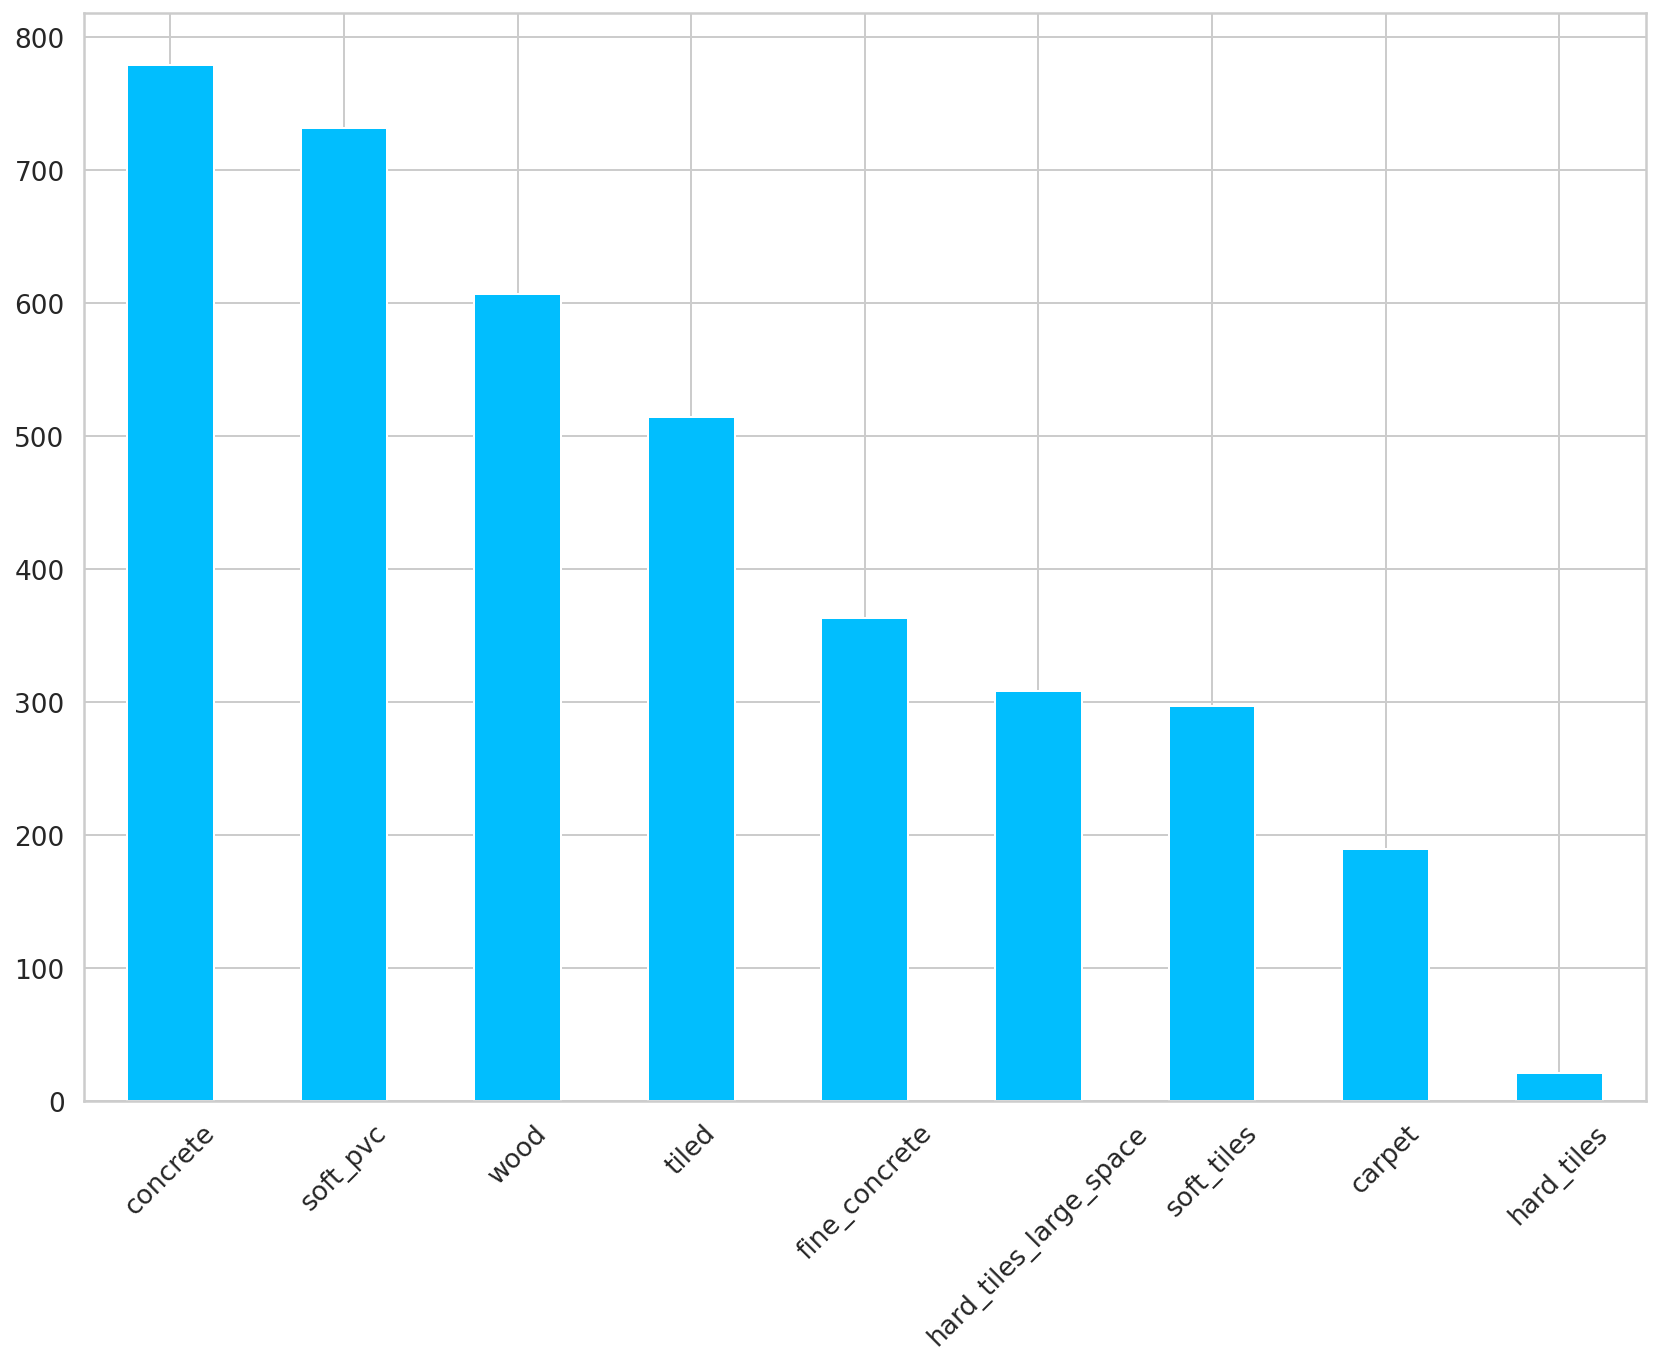

In [48]:
# Checking Data Distribution
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# We see that this is not ideal. More data samples of few kind.
# We have unbalaced data
# We might want to use some sort of resampling or balancing the dataset

### Preprocessing the data

In [49]:
# Changing from String Labels to Interger Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)
print(encoded_labels[:10])
print("Label Classes: ", label_encoder.classes_)

[2 1 1 1 6 7 5 1 4 7]
Label Classes:  ['carpet' 'concrete' 'fine_concrete' 'hard_tiles' 'hard_tiles_large_space'
 'soft_pvc' 'soft_tiles' 'tiled' 'wood']


In [50]:
# Adding to y_train df
y_train["label"] = encoded_labels
y_train

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
...,...,...,...,...
3805,3805,55,tiled,7
3806,3806,67,wood,8
3807,3807,48,fine_concrete,2
3808,3808,54,tiled,7


In [51]:
# We only need certain features
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [52]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [53]:
print(X_train.series_id.value_counts())
# This shows us that each sequence contains 128 datapoints

# confirming this
(X_train.series_id.value_counts() == 128).sum() == len(y_train)


0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64


True

### Creating the sequences

I will group by series id

In [54]:
sequences = []
for series_id, group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id == series_id].iloc[0].label
    sequences.append((sequence_features, label))

In [55]:
# Each sequence
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

#### Splitting the Sequences into Training and Test Sequences

In [59]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
print("Number of Training Sequences: ", len(train_sequences))
print("Number of Testing Sequences: ", len(test_sequences))

Number of Training Sequences:  3048
Number of Testing Sequences:  762
